<a href="https://colab.research.google.com/github/serdarakgun/Handwriting-Recognition-and-Translation-Using-Deep-Learning-and-DeepL-API/blob/main/Handwriting_Arabic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub matplotlib seaborn tensorflow keras pandas scikit-learn -q
import os, warnings
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import tensorflow as tf
import pandas as pd
import keras
import kagglehub
import random
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, RandomContrast, RandomFlip,  RandomRotation, RandomTranslation
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from PIL import Image
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")



In [48]:
# Download latest version
path = kagglehub.dataset_download("mloey1/ahcd1")

print("Path to dataset files:", path)



# Dataset içindeki dosyaları listele
for root, dirs, files in os.walk(path):
    print("Dataset içindeki dosyalar:", files)

Path to dataset files: /root/.cache/kagglehub/datasets/mloey1/ahcd1/versions/2
Dataset içindeki dosyalar: ['csvTrainLabel 13440x1.csv', 'csvTestImages 3360x1024.csv', 'csvTestLabel 3360x1.csv', 'Train+Test Images Matlab.mat', 'csvTrainImages 13440x1024.csv']
Dataset içindeki dosyalar: []
Dataset içindeki dosyalar: ['id_7100_label_20.png', 'id_1176_label_7.png', 'id_5201_label_7.png', 'id_8401_label_15.png', 'id_3252_label_15.png', 'id_8706_label_25.png', 'id_8276_label_27.png', 'id_4398_label_18.png', 'id_460_label_2.png', 'id_5606_label_1.png', 'id_11216_label_2.png', 'id_10823_label_9.png', 'id_10073_label_28.png', 'id_909_label_2.png', 'id_2691_label_1.png', 'id_7534_label_18.png', 'id_9139_label_23.png', 'id_12960_label_24.png', 'id_9515_label_14.png', 'id_5453_label_10.png', 'id_2516_label_7.png', 'id_1691_label_16.png', 'id_4507_label_4.png', 'id_13292_label_10.png', 'id_2169_label_20.png', 'id_7746_label_17.png', 'id_8876_label_18.png', 'id_1832_label_5.png', 'id_4453_label_25.p

In [49]:
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(333)

x_train shape: (13440, 1024)
y_train shape: (13440, 1)
x_test shape: (3360, 1024)
y_test shape: (3360, 1)


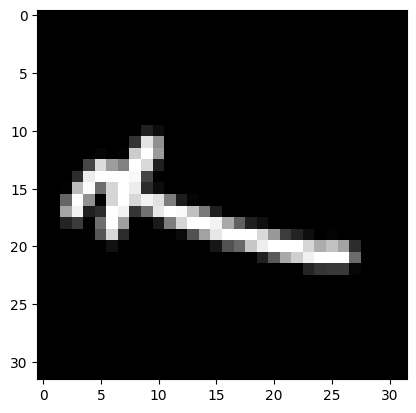

13440

In [50]:
# Load Data
data_path = "/root/.cache/kagglehub/datasets/mloey1/ahcd1/versions/2"

# Eğitim ve test veri dosyalarının tam yolunu belirtiyoruz
x_train = pd.read_csv(os.path.join(data_path, "csvTrainImages 13440x1024.csv"), header=None)
y_train = pd.read_csv(os.path.join(data_path, "csvTrainLabel 13440x1.csv"), header=None)
x_test = pd.read_csv(os.path.join(data_path, "csvTestImages 3360x1024.csv"), header=None)
y_test = pd.read_csv(os.path.join(data_path, "csvTestLabel 3360x1.csv"), header=None)

# Verileri kontrol etmek için ilk birkaç satırı görüntüleme (isteğe bağlı)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
image_data = x_train.iloc[0].values.reshape(32, 32)  # Örneğin, 32x32 boyutunda bir görüntü

# Görüntüyü göster
plt.imshow(image_data, cmap='gray')
plt.show()
x_train.shape[0]

In [51]:
# Reshape our input data to image shape (32*32)
x_train = x_train.to_numpy().reshape(-1,32,32,1)
x_test = x_test.to_numpy().reshape(-1,32,32,1)

# transform our categorial label to be one hot encoded
y_train = to_categorical(y_train-1)
y_test = to_categorical(y_test-1)

# split train data to craete a validiatation data
(train_inputs, validate_inputs, train_targets, validate_targets) = train_test_split(x_train, y_train, test_size=0.10)

In [63]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, AveragePooling2D, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import os

# TensorFlow deterministik olmayan işlemleri devre dışı bırakmak için ayar
os.environ["TF_DETERMINISTIC_OPS"] = "1"

def get_fixed_model():
    In = Input(shape=(32, 32, 1))

    # First block
    x = Conv2D(32, (3, 3), padding="same", activation="relu", kernel_regularizer=l2(1e-4))(In)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding="same", activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = AveragePooling2D((2, 2))(x)  # Output: (16, 16, 32)
    x = Dropout(0.3)(x)

    # Second block
    x = Conv2D(64, (3, 3), padding="same", activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding="same", activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = AveragePooling2D((2, 2))(x)  # Output: (8, 8, 64)
    x = Dropout(0.4)(x)

    # Third block
    x = Conv2D(128, (3, 3), padding="same", activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding="same", activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = AveragePooling2D((2, 2))(x)  # Output: (4, 4, 128)
    x = Dropout(0.5)(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)

    # Output layer
    Out = Dense(28, activation="softmax")(x)

    # Model compilation
    model = Model(In, Out)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=1e-3),
        metrics=["accuracy"]
    )

    return model




model = get_fixed_model()
plot_model(model, show_shapes=True, show_layer_names=True)

# Augmentation for training data only
datagen = ImageDataGenerator(
    brightness_range=(0.5, 1.5),
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

batch_size = 40

train_data = datagen.flow(train_inputs, train_targets, batch_size=batch_size)
validate_data = ImageDataGenerator().flow(validate_inputs, validate_targets, batch_size=batch_size)

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Model fitting
history = model.fit(train_data, validation_data=validate_data, epochs=50, callbacks=[reduce_lr])


Epoch 1/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 28s 60ms/step - accuracy: 0.1079 - loss: 3.0952 - val_accuracy: 0.3981 - val_loss: 1.6692 - learning_rate: 0.0010
Epoch 2/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.4220 - loss: 1.8001 - val_accuracy: 0.6905 - val_loss: 0.9980 - learning_rate: 0.0010
Epoch 3/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.6247 - loss: 1.2427 - val_accuracy: 0.7292 - val_loss: 0.9481 - learning_rate: 0.0010
Epoch 4/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.7100 - loss: 0.9942 - val_accuracy: 0.8289 - val_loss: 0.5957 - learning_rate: 0.0010
Epoch 5/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.7562 - loss: 0.8873 - val_accuracy: 0.8579 - val_loss: 0.5625 - learning_rate: 0.0010
Epoch 6/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.7736 - loss: 0.8079 - val_accuracy: 0.9115 - val_loss: 0.4010 - learning_rate: 0.0010
Epoch 7/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.7867 - l

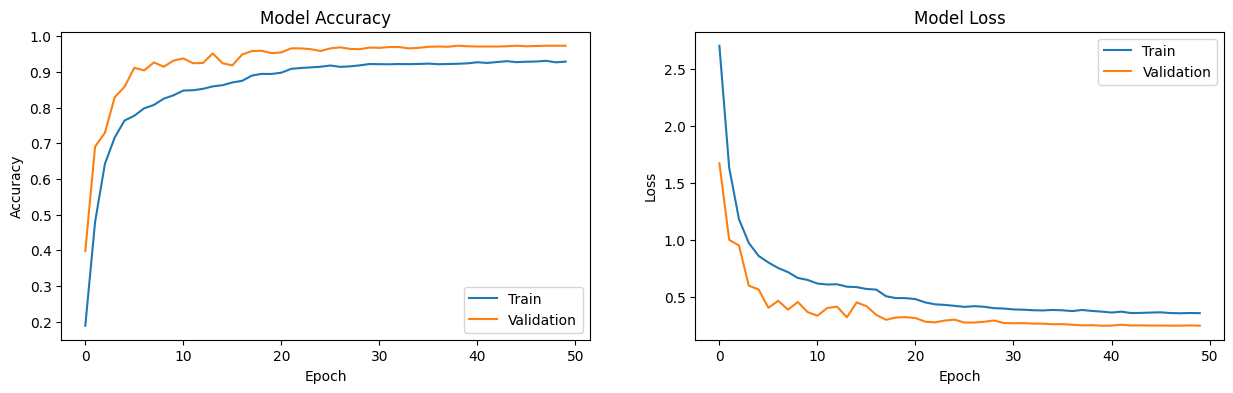

In [75]:
# Plot two plots of accuracy and loss for both train and validation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Plot train and validation accuracy
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'])

# Plot train and validation accuracy loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'])

plt.show()

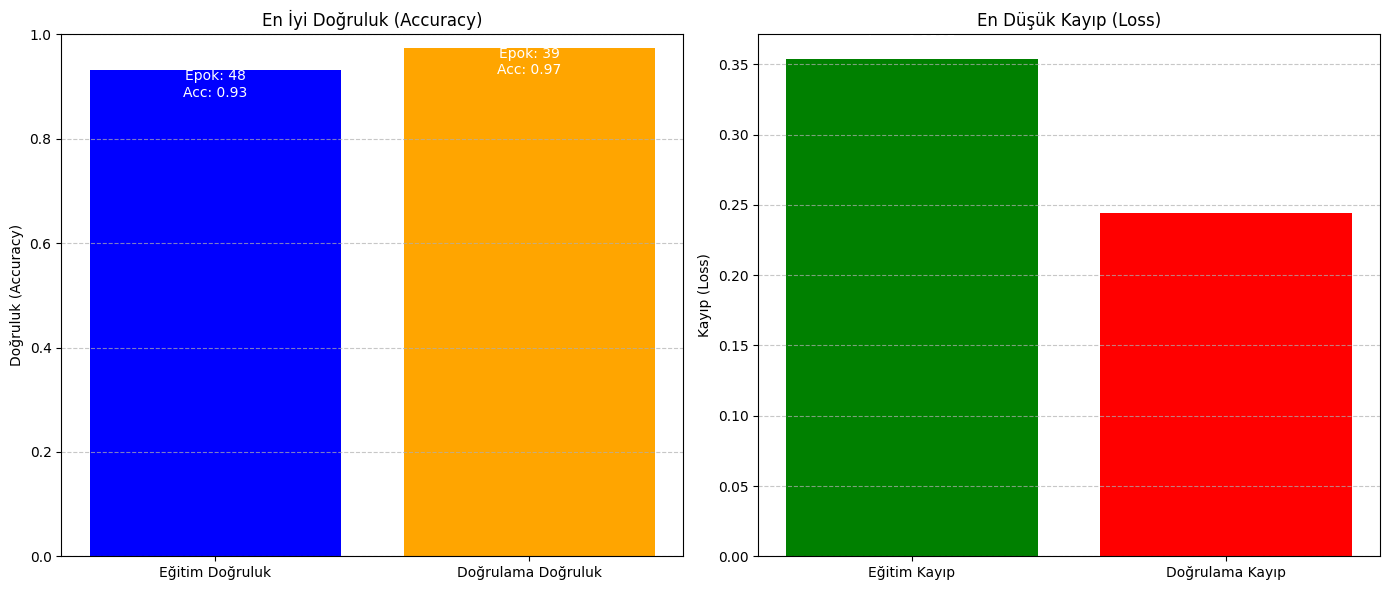

In [79]:
import matplotlib.pyplot as plt

# History'den verileri alalım
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# En iyi doğruluk ve en düşük kayıp değerlerini tespit edelim
best_train_acc = max(accuracy)
best_train_epoch_acc = accuracy.index(best_train_acc) + 1  # En iyi epok
best_val_acc = max(val_accuracy)
best_val_epoch_acc = val_accuracy.index(best_val_acc) + 1

lowest_train_loss = min(loss)
lowest_train_epoch_loss = loss.index(lowest_train_loss) + 1
lowest_val_loss = min(val_loss)
lowest_val_epoch_loss = val_loss.index(lowest_val_loss) + 1

# Sütun grafiği için veriler
categories_accuracy = ['Eğitim Doğruluk', 'Doğrulama Doğruluk']
values_accuracy = [best_train_acc, best_val_acc]

categories_loss = ['Eğitim Kayıp', 'Doğrulama Kayıp']
values_loss = [lowest_train_loss, lowest_val_loss]

# Accuracy Sütun Grafiği
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.bar(categories_accuracy, values_accuracy, color=['blue', 'orange'])
plt.ylim(0, 1)  # Doğruluklar 0 ile 1 arasında
plt.title('En İyi Doğruluk (Accuracy)')
plt.ylabel('Doğruluk (Accuracy)')
plt.text(0, best_train_acc - 0.05, f'Epok: {best_train_epoch_acc}\nAcc: {best_train_acc:.2f}', ha='center', color='white', fontsize=10)
plt.text(1, best_val_acc - 0.05, f'Epok: {best_val_epoch_acc}\nAcc: {best_val_acc:.2f}', ha='center', color='white', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Loss Sütun Grafiği
plt.subplot(1, 2, 2)
plt.bar(categories_loss, values_loss, color=['green', 'red'])
plt.title('En Düşük Kayıp (Loss)')
plt.ylabel('Kayıp (Loss)')
plt.text(0, lowest_train_loss + 0.01, f'Epok: {lowest_train_epoch_loss}\nLoss: {lowest_train_loss:.4f}', ha='center', color='white', fontsize=10)
plt.text(1, lowest_val_loss + 0.01, f'Epok: {lowest_val_epoch_loss}\nLoss: {lowest_val_loss:.4f}', ha='center', color='white', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [65]:
# Test model performance using test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('The model accuracy is ' + f"{test_accuracy*100:.1f}" + '%')

105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9726 - loss: 0.2376
The model accuracy is 97.6%


In [66]:
model.summary()
model.save("Arabic_handwriiten_CNN_Model.keras")
from google.colab import drive

# Google Drive
drive.mount('/content/drive')
model.save('/content/drive/MyDrive/Arabic_handwriiten_CNN_Model.keras')

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_4                  │ (None, 16, 16, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_56 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_5                  │ (None, 8, 8, 64)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_59 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_6                  │ (None, 4, 4, 128)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │          33,0

 Total params: 981,750 (3.75 MB)

 Trainable params: 327,100 (1.25 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 654,202 (2.50 MB)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
num_to_arabic = {
    1: "ا",
    2: "ب",
    3: "ت",
    4: "ث",
    5: "ج",
    6: "ح",
    7: "خ",
    8: "د",
    9: "ذ",
    10: "ر",
    11: "ز",
    12: "س",
    13: "ش",
    14: "ص",
    15: "ض",
    16: "ط",
    17: "ظ",
    18: "ع",
    19: "غ",
    20: "ف",
    21: "ق",
    22: "ك",
    23: "ل",
    24: "م",
    25: "ن",
    26: "ه",
    27: "و",
    28: "ي"
}


In [68]:
# Numara etiketlerini harfe dönüştürme
def convert_labels_to_arabic(labels, mapping):
    return [mapping.get(label + 1, '') for label in labels] # Use get with default value to handle missing keys
# Örnek kullanım
num_labels = [1, 2, 3, 10, 28]  # Örnek olarak verilen numara etiketleri
arabic_labels = convert_labels_to_arabic(num_labels, num_to_arabic)
print("Arabic Labels:", arabic_labels)
# Çıktı: ['ا', 'ب', 'ت', 'ر', 'ي']


Arabic Labels: ['ب', 'ت', 'ث', 'ز', '']


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


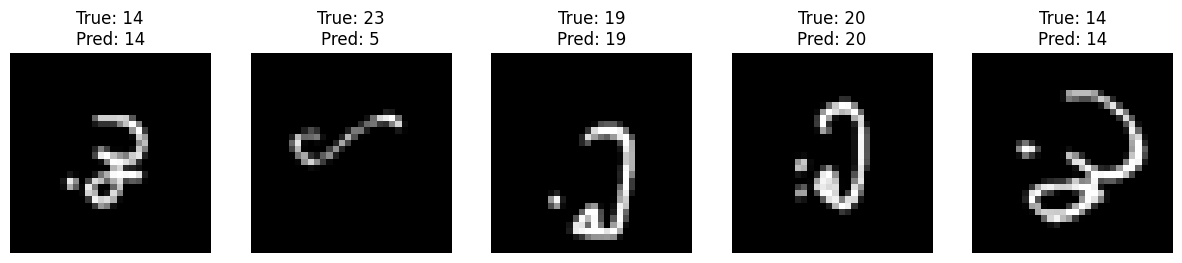

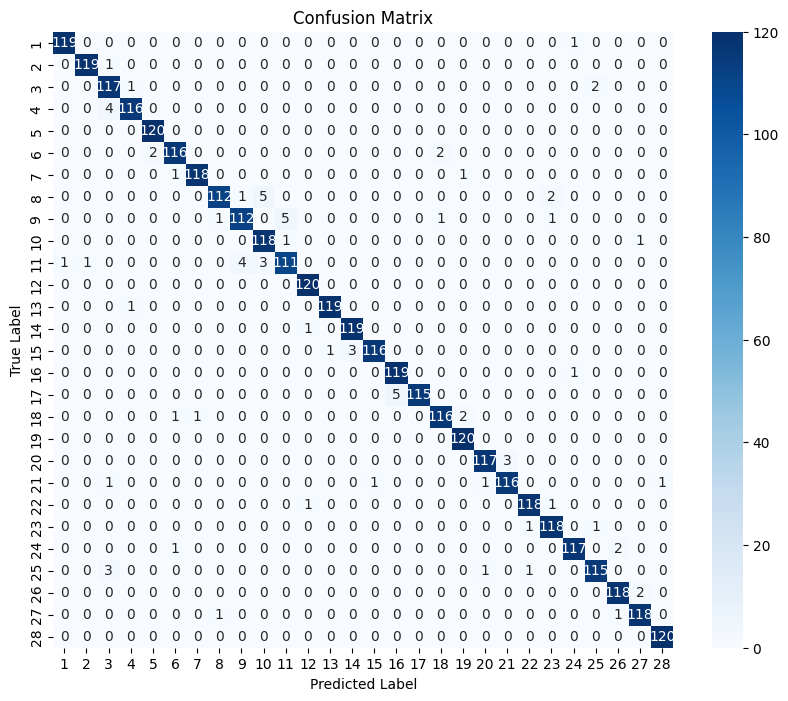

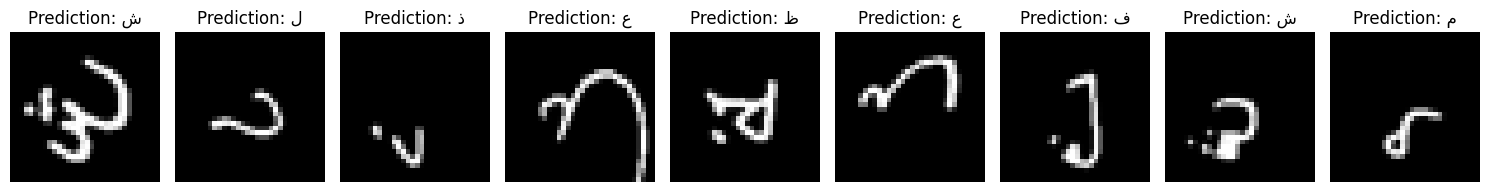

In [69]:
# Prediction Function

def predict_random_samples(model, x_test, y_test, num_samples=5):
    """
    Predicts random samples from the test set and displays the images alongside the predictions.
    """
    indices = random.sample(range(len(x_test)), num_samples)
    selected_images = x_test[indices]
    true_labels = np.argmax(y_test[indices], axis=1)
    predictions = model.predict(selected_images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Plot the selected samples with true and predicted labels
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(selected_images):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
        plt.axis('off')
    plt.show()

# Confusion Matrix Function
def plot_confusion_matrix(y_true, y_pred):
    """
    Plots a confusion matrix for the true vs predicted labels.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 29), yticklabels=range(1, 29))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Grid Visualization Function
def show_img_grid(images, labels, N, mapping):
    fig, axes = plt.subplots(1, N, figsize=(15, 5))
    arabic_labels = convert_labels_to_arabic(labels, mapping)
    for i in range(N):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(f"Prediction: {arabic_labels[i]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


# Predictions and Confusion Matrix
predicted_probs = model.predict(x_test)
y_pred = np.argmax(predicted_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Call Functions
predict_random_samples(model, x_test, y_test, num_samples=5)
plot_confusion_matrix(y_true, y_pred)

# Example for Grid Visualization
N = 9  # Number of images to display
grid_images = []
grid_labels = []

for i in range(N):
    idx = random.randint(0, len(x_test) - 1)
    grid_images.append(x_test[idx].squeeze())
    grid_labels.append(y_pred[idx])

show_img_grid(grid_images, grid_labels, N, num_to_arabic)




In [70]:
# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(1, 29)]))


Classification Report:

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       120
           2       0.99      0.99      0.99       120
           3       0.93      0.97      0.95       120
           4       0.98      0.97      0.97       120
           5       0.98      1.00      0.99       120
           6       0.97      0.97      0.97       120
           7       0.99      0.98      0.99       120
           8       0.98      0.93      0.96       120
           9       0.96      0.93      0.95       120
          10       0.94      0.98      0.96       120
          11       0.95      0.93      0.94       120
          12       0.98      1.00      0.99       120
          13       0.99      0.99      0.99       120
          14       0.98      0.99      0.98       120
          15       0.99      0.97      0.98       120
          16       0.96      0.99      0.98       120
          17       1.00      0.96      0.98       120
  